## Problem 1: Visualise data in a static map (10 points)


Create a *static* **thematic map** using the skills you learnt during lesson 5. The map should <br>
contain more than one layer (from at least two different data sets). Pay attention to classification <br>
and visualisation (appropriate colour scheme choice, etc.). Write your code in this notebook, and <br>
store the resulting maps in `.png` format in the `NOTEBOOK_DIRECTORY / "docs"` folder.

### Topic of the map

- Use any of the data sets we have used during the course (travel time data, population grid), or <br>
  any other data set of your interest (for example, [open data sets from Statistics Finland](https://www.stat.fi/org/avoindata/index_en.html), <br>
  or the open geo-data from [the Helsinki Region Infoshare](https://hri.fi/en)). If you download <br>
  data sets, add, commit, and push them to the `DATA_DIRECTORY`. Be sure to include an attribution <br>
  to each data set in your output map!
- Feel free to start from and adapt examples from the course material! You can take one step further <br>
  and add additional analysis to, e.g., the shopping centre dominance or the population within vincinity <br>
  of certain addresses)

### Criteria

- The map has more than one data layer (for instance, the results of an analysis, and the road network <br>
  to illustrate a complex spatial pattern). If (and only if) you think it adds additional value, feel <br>
  free to add a base map (but a base map does not count as an own layer)
- The map portrays the output of an analysis or a classification that adds value beyond just displaying <br>
  the raw data
- The map follows good cartographic practices (appropriate map extent and zoom level, colour scheme, <br>
  legend and data sources, etc.)

### Output

- Save the map(s) in `.png` format in the `NOTEBOOK_DIRECTORY / "docs"` folder, remember to add, commit, <br>
  and push them to the GitHub repository
- Remember to also add, commit, and push input data sets and code

---

In [1]:
import pathlib 
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"
OUTPUT_DIRECTORY = NOTEBOOK_PATH / "docs"

In [2]:
# ADD YOUR OWN CODE HERE
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily
import folium
import requests
import zipfile
from shapely.geometry import box

/tmp/ipykernel_4465/1561631395.py:3: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [3]:
# Downloads and extracting data from .zip files
# Data from Helsinki Region Infoshare
vuln_map_uri = "https://www.hel.fi/hel2/Tietokeskus/data/helsinki/kaupunginkanslia/Urban_Heat_Vulnerability_Map_of_Helsinki/Geographic_JavaScript_Object_Notation_GeoJSON.zip"
vuln_map_zip_file_path = DATA_DIRECTORY / "Geographic_JavaScript_Object_Notation_GeoJSON.zip"

with open(vuln_map_zip_file_path, "wb") as file:
    response = requests.get(vuln_map_uri)
    file.write(response.content)

with zipfile.ZipFile(vuln_map_zip_file_path, "r") as archive:
    archive.extractall(DATA_DIRECTORY)

# data created by http://urclim.prod.lamp.cnrs.fr/
heat_stress_zip_file_path = DATA_DIRECTORY / "T2M_JJA_shp.zip"
heat_stress_uri = "https://avoidatastr.blob.core.windows.net/avoindata/AvoinData/3_Ilmanlaatu_ja_ilmasto/Ilmasto/URCLIM_kaupunkisaamalli/T2M_JJA_shp.zip"

with open(heat_stress_zip_file_path, "wb") as file:
    response = requests.get(heat_stress_uri)
    file.write(response.content)

with zipfile.ZipFile(heat_stress_zip_file_path, "r") as archive:
    archive.extractall(DATA_DIRECTORY / "temperature")
    
# https://hri.fi/data/en_GB/dataset/kaupunkisaamallin-tuloksia-lampomukavuudesta-ja-liukkaista-keleista-paakaupunkiseudulla
temp_1951_path = "data/temperature/H107_T2M_JJA.shp" # Average daily temperature estimates for June - August 1951, calculated by the URCLIM model at a height of two meters
temp_2055_path = "data/temperature/H327_T2M_JJA.shp" # Average daily temperature estimates for June - August 2055, calculated by the URCLIM model at a height of two meters

roads_WFS_URL = (
    "https://kartta.hel.fi/ws/geoserver/avoindata/wfs"
    "?service=wfs"
    "&version=2.0.0"
    "&request=GetFeature"
    "&srsName=EPSG:3879"
    "&typeName={layer:s}"
).format(layer="avoindata:Seutukartta_liikenne_paatiet")

In [4]:
vuln_map_df = gpd.read_file(DATA_DIRECTORY / "Geographic_JavaScript_Object_Notation_GeoJSON/Urban Heat Vulnerability Dataset for Helsinki, Finland.geojson")

# Restricting the vulnerability to only a few relevant coluns such as 'HVP: Heat Vulnerable Population' and geometry
relevant_vuln_map_cols = [col_name for col_name in vuln_map_df.columns if not any(excluded_value in col_name for excluded_value in ("TP-AG", "Avg-U", "UHSI"))]
vuln_map_df = vuln_map_df[relevant_vuln_map_cols]

# Getting just the polygons corresponding to the upper 5% percentile of Heat Vulnerable Population
vuln_map_df = vuln_map_df[vuln_map_df["HVP: Heat Vulnerable Population"] > vuln_map_df["HVP: Heat Vulnerable Population"].quantile(0.95)]

temp_1951_df = gpd.read_file(temp_1951_path)
temp_2055_df = gpd.read_file(temp_2055_path)

# roads df
roads_df = gpd.read_file(roads_WFS_URL).set_crs(vuln_map_df.crs)

# temp_df = temp_df.to_crs(vuln_map_df.crs) # in case not...
# cheching if the crs matches for all dfs
assert roads_df.crs == vuln_map_df.crs == temp_1951_df.crs == temp_2055_df.crs

In [5]:
# Creating function for constricting the area for analysis/processing of a df
def bound_df(df_for_bbox, df_to_bound):
    """ Function accepts a df_to_bound using the bounding box (bbox) of df_for_bbox """
    bounds = df_for_bbox.bounds
    minx, miny, maxx, maxy = (bounds.minx.min(), 
                             bounds.miny.min(),
                             bounds.maxx.max(),
                             bounds.maxy.max())
    bbox = box(minx, miny, maxx, maxy)
    return df_to_bound[df_to_bound.geometry.within(bbox)]

In [6]:
# Bounding roads and temp dfs inside helsinki area
roads_df = bound_df(vuln_map_df, roads_df)
temp_1951_df = bound_df(vuln_map_df, temp_1951_df)
temp_2055_df = bound_df(vuln_map_df, temp_2055_df).drop(columns=["geometry"]) # this column is not necessery for the subsequent join

# converting kelvin temperatures to celsius
temp_1951_df.value = temp_1951_df.value - 273.15
temp_2055_df.value = temp_2055_df.value - 273.15

# Renaming value column for 1951 and 2055 dfs
temp_1951_df = temp_1951_df.rename(columns={"value": "value_1951"})
temp_2055_df = temp_2055_df.rename(columns={"value": "value_2055"})

# Joining data from temperature dfs
temperature_df = temp_1951_df.join(temp_2055_df, rsuffix="_2055" )

# Creating temperature change variable
temperature_df["temp_change"] = temperature_df.value_2055 - temperature_df.value_1951

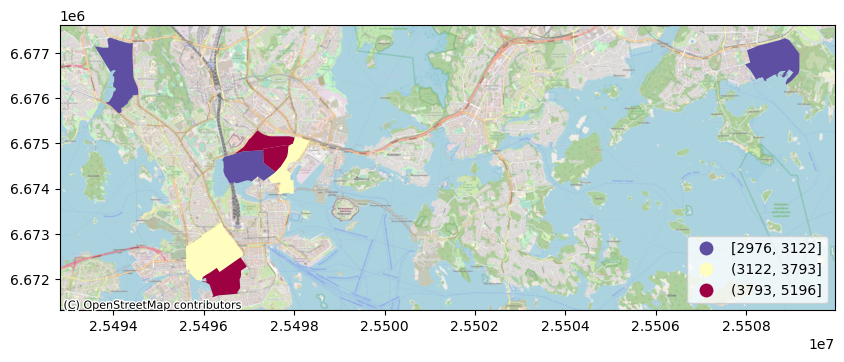

In [7]:
# This map shows the districts containing the upper 5% percentile of Heat Vulnerable Population   
ax0 = vuln_map_df.plot(
    figsize=(10, 5),
    column="HVP: Heat Vulnerable Population",
    scheme="quantiles",
    cmap="Spectral_r",
    linewidth=1,
    alpha=1,
    legend=True,
    k=3,
    legend_kwds={
        'loc':'lower right',
        "fmt": "{:.0f}",
    "interval":True,
    }    
)

# Add a basemap
contextily.add_basemap(
    ax=ax0,
    source=contextily.providers.OpenStreetMap.Mapnik,
    crs=temperature_df.crs
)

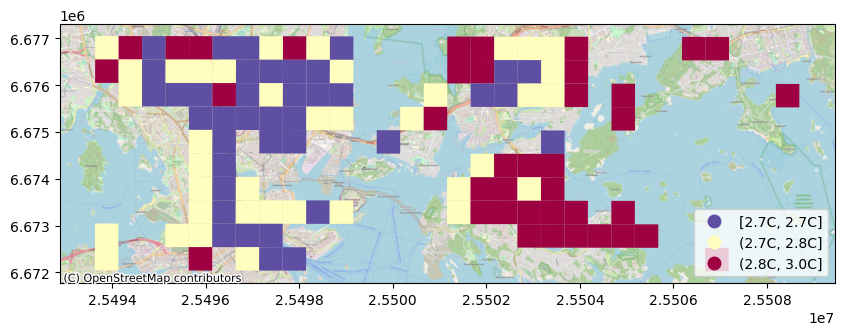

In [8]:
# This map shows the modeled temperature increase from 1951 to 2055 within the same area as above
ax1 = temperature_df.plot(
    figsize=(10, 5),
    column="temp_change",
    scheme="quantiles",
    cmap="Spectral_r",
    linewidth=1,
    alpha=1,
    legend=True,
    k=3,
    legend_kwds={
        'loc':'lower right',
        "fmt": "{:.1f}C",
    "interval":True,
    }    
)

# Add a basemap
contextily.add_basemap(
    ax=ax1,
    source=contextily.providers.OpenStreetMap.Mapnik,
    crs=temperature_df.crs
)

In [9]:
# Get the HVP: Heat Vulnerable Population data in the vuln_map_df (the one which has the districts polygon) using a spatial join
analysis_df = vuln_map_df.sjoin(
    temperature_df,
    how="left", predicate="intersects"
)

# Create an analysis df by 
analysis_df = analysis_df.groupby("ID: District ID").agg({"Name: District Name":"first", "HVP: Heat Vulnerable Population":"first", 'temp_change' : "mean", "geometry":"first"}).reset_index()
analysis_gdf = gpd.GeoDataFrame(analysis_df,  geometry = "geometry").dropna()

In [10]:
roads_df = bound_df(analysis_gdf, roads_df)

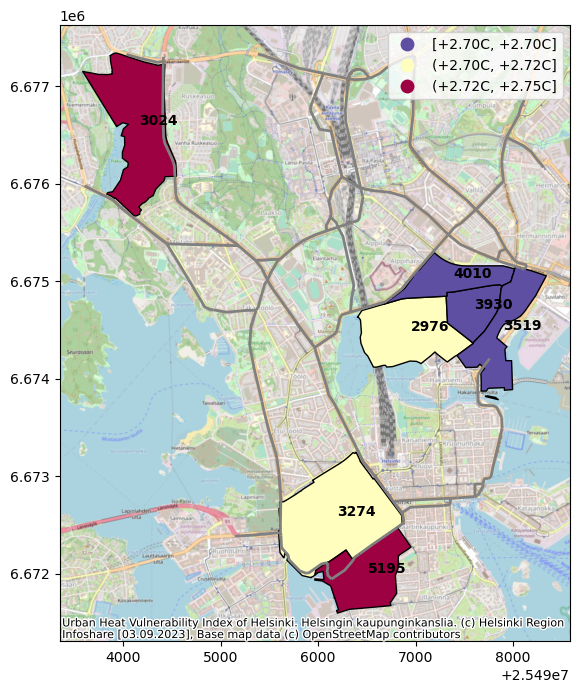

In [11]:
ax = analysis_gdf.plot(
    figsize=(12, 8),
    column="temp_change",
    scheme="quantiles",
    k=3,
    cmap="Spectral_r",    
    linewidth=1,
    edgecolor="black",
    legend=True,
    legend_kwds={
        'loc':'upper right',
        "fmt": "+{:.2f}C",
    "interval":True,
    },
    alpha=1)

# Loop through the rows and add text labels
for x, y, label in zip(analysis_gdf.geometry.centroid.x, analysis_gdf.geometry.centroid.y, analysis_gdf['HVP: Heat Vulnerable Population']):
    plt.annotate(int(label), 
                 xy=(x, y), 
                 xytext=(1, 1), 
                 textcoords="offset points", 
                 color='black', fontweight='bold')

roads_df.plot(
    ax=ax,
    color="grey",
    linewidth=2,
    alpha=1,

)

# Add a basemap
contextily.add_basemap(
    ax=ax,
    source=contextily.providers.OpenStreetMap.Mapnik,
    crs=vuln_map_df.crs,
    attribution=(
        "Urban Heat Vulnerability Index of Helsinki. Helsingin kaupunginkanslia. (c) Helsinki Region Infoshare [03.09.2023], " 
        "Base map data (c) OpenStreetMap contributors"
    )
)